Build emulator for the SVD components of $\{ P_0(k | \theta_i) \}_{i \in LHD}$ for 2 dimensions of $\theta$ (for simplicity)

In [1]:
import numpy as np 
import scipy as sp
import george as George
import nbodykit.lab as NBlab

# -- local -- 
import env
import lhd as LHD
import data as Dat
import compress as Cmprs
import forwardmodel as FM 

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Lets begin by constructing $\{\theta_i\}^{LHD}$s of the Latin Hypercube Design, which will be used to train the GP.

In [7]:
# 2D Latin Hypercube Design
lhd_2d = LHD.LHD(2, samples=17, method='mdu')


In [21]:
theta_lhd = np.zeros((lhd_2d.shape[0], 5))
theta_lhd[:,0] = 11.60 # log M_min
theta_lhd[:,1] = 0.26  # sigma_logM
theta_lhd[:,2] = 11.49 # log M0
theta_lhd[:,3] = 12.2 + lhd_2d[:,0].flatten()  # log M1 sampled by LHD
theta_lhd[:,4] = 0.5 + lhd_2d[:,1].flatten() # alpha sampled by LHD
keylist = ['$\log\,M_{min}$', '$\sigma_{\log M}$', r'$\log M_0$', r'$\log M_1$', r'$\alpha$']
print keylist
print theta_lhd[:5,:]

['$\\log\\,M_{min}$', '$\\sigma_{\\log M}$', '$\\log M_0$', '$\\log M_1$', '$\\alpha$']
[[ 11.6          0.26        11.49        12.65162143   1.00324711]
 [ 11.6          0.26        11.49        12.78921105   1.47233239]
 [ 11.6          0.26        11.49        13.17129959   1.16128543]
 [ 11.6          0.26        11.49        13.03685269   0.79959428]
 [ 11.6          0.26        11.49        12.76736311   0.72924799]]


Now lets construct set of $\theta$ to test the GP

In [52]:
theta_test = theta_lhd[:10,:].copy() # 10 training parameter points
t_min = [11.4, 0.2, 9., 12.5, 0.8]
t_max = [11.8, 0.4, 12., 12.9, 1.2]
for i in [3,4]: 
    ti = np.linspace(t_min[i], t_max[i], theta_test.shape[0])
    np.random.shuffle(ti)
    theta_test[:,i] = ti
print keylist
print theta_test[:5,:]

['$\\log\\,M_{min}$', '$\\sigma_{\\log M}$', '$\\log M_0$', '$\\log M_1$', '$\\alpha$']
[[ 11.6          0.26        11.49        12.85555556   1.02222222]
 [ 11.6          0.26        11.49        12.58888889   0.93333333]
 [ 11.6          0.26        11.49        12.72222222   0.97777778]
 [ 11.6          0.26        11.49        12.76666667   1.11111111]
 [ 11.6          0.26        11.49        12.63333333   1.06666667]]


## Construct $\{P(k|\theta_i)\}_{i\in LHD}$  and $\{P(k|\theta_i)\}_{i\in test}$ 

In [8]:
def BigF(theta, halos): 
    # F(theta) --- i.e. the galaxy catalog generated
    # from the halo catalog
    p_hod = {'logMmin': theta[0], 'sigma_logM': theta[1], 'logM0': theta[2], 'logM1': theta[3], 'alpha': theta[4]}
    g = FM.Galaxies(halos, p_hod, seed=seed)
    g['RSDPosition'] = FM.RSD(g, LOS=[0,0,1]) # impose RSD
    return g

def ObvsBigF(bigf, obvs='p0k'):
    # measure P(k) from F(theta)
    plk_i = FM.Observables(bigf, observable='plk', Nmesh=360, rsd=True)
    klim = np.where((plk_i['k'] > 0.01) & (plk_i['k'] < 0.5))
    return plk_i['k'][klim], plk_i['p0k'][klim]

In [9]:
# Read in halo catalog
halos = Dat.NeutHalos(0.0, 1, 4)

In [11]:
# designate random seed
seed = 10
np.random.seed(seed)

First $\{P(k|\theta_i)\}_{i\in LHD}$

In [12]:
pk_lhd = []
for i in range(theta_lhd.shape[0]): 
    gals_i = BigF(theta_lhd[i,:], halos)
    kk, p0k_i = ObvsBigF(gals_i, obvs='p0k')
    pk_lhd.append(p0k_i)
    if i == 0: karr = kk
pk_lhd = np.array(pk_lhd)

Then $\{P(k|\theta_i)\}_{i\in test}$

In [53]:
pk_test = []
for i in range(theta_test.shape[0]): 
    gals_i = BigF(theta_test[i,:], halos)
    kk, p0k_i = ObvsBigF(gals_i, obvs='p0k')
    pk_test.append(p0k_i)
pk_test = np.array(pk_test)

Here's what the $P(k|\theta_i)$s look like

(0.5, 1.5)

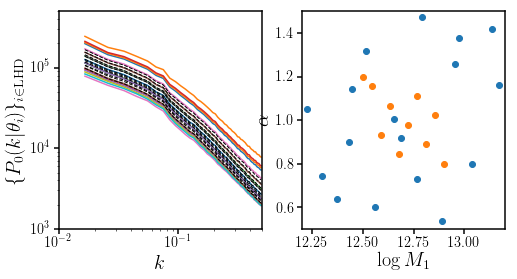

In [54]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(121)
sub2 = fig.add_subplot(122)
for i in range(pk_lhd.shape[0]): 
    sub.plot(karr, pk_lhd[i,:])
for i in range(pk_test.shape[0]):
    sub.plot(karr, pk_test[i,:], c='k', ls='--', lw=1)
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel(r'$\{P_0(k|\theta_i)\}_{i \in \mathrm{LHD}}$', fontsize=20)
sub.set_ylim([10**3, 5e5])
sub.set_yscale('log')

sub2.scatter(theta_lhd[:,3], theta_lhd[:,4])
sub2.scatter(theta_test[:,3], theta_test[:,4])
sub2.set_xlabel(keylist[3], fontsize=20)
sub2.set_xlim([12.2, 13.2])
sub2.set_ylabel(keylist[4], fontsize=20)
sub2.set_ylim([0.5, 1.5])

Get the SVD components of the LHD.

In [117]:
n_comp = 3
svd_lhd = Cmprs.Svd(n_comp=n_comp)
_ = svd_lhd.fit(pk_lhd)

In [118]:
X_lhd = svd_lhd._white(pk_lhd)
X_test = svd_lhd._white(pk_test)

$\{P(k|\theta_i)\}_{i\in LHD}$ whitened by subtracting out the mean and scaling by the standard deviation

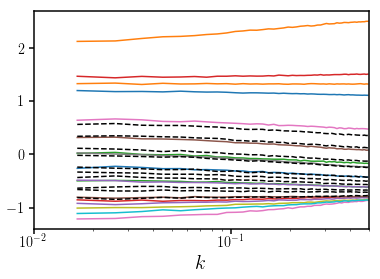

In [119]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pk_lhd.shape[0]): 
    sub.plot(karr, X_lhd[i,:])
for i in range(pk_test.shape[0]): 
    sub.plot(karr, X_test[i,:], c='k', ls='--')
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')

In [120]:
pc_lhd = svd_lhd.transform(pk_lhd)
pc_test = svd_lhd.transform(pk_test)

In [121]:
# explained variance
print svd_lhd.n_comp, ' components'
print svd_lhd.exp_var_ratio[:n_comp]

3  components
[  9.97005161e-01   2.96948879e-03   7.99380624e-06]


Test SVD transformation

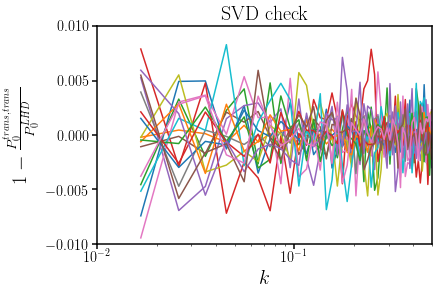

In [122]:
pc_lhd_inv = svd_lhd.inv_transform(pc_lhd)
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pc_lhd.shape[0]): 
    sub.plot(karr, 1.-pc_lhd_inv[i,:]/pk_lhd[i,:])
sub.set_xlabel('$k$', fontsize=20)
sub.set_xscale('log')
sub.set_xlim([0.01,0.5])
sub.set_ylabel(r'$1 - \frac{P_0^{trans,trans}}{P_0^{LHD}}$', fontsize=20)
sub.set_ylim([-0.01, 0.01])
sub.set_title("SVD check", fontsize=20)

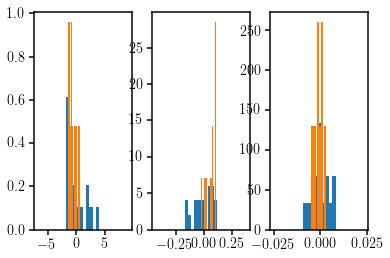

In [123]:
fig = plt.figure()
for i in range(np.min([n_comp, 3])):
    sub = fig.add_subplot(1,3,i+1)
    _ = sub.hist(pc_lhd[:,i], normed=True) # LHD
    _ = sub.hist(pc_test[:,i], normed=True) # test

In [124]:
def trainGP(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    lguess = [(np.max(X[:,i]) - np.min(X[:,i]))/float(X.shape[0]) for i in range(X.shape[1])]

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess, ndim=X.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_mean=True)
        gp.compute(X)
        gps.append(gp)
    return gps


def trainGP_opt(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    lguess = [(np.max(X[:,i]) - np.min(X[:,i]))/float(X.shape[0]) for i in range(X.shape[1])]

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess, ndim=X.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_mean=True)
        gp.compute(X)
        # optimize hyperparameters
        p0 = gp.get_parameter_vector()
        results = sp.optimize.minimize(gp.nll, p0, args=(Y[:,i]), jac=gp.grad_nll, method='L-BFGS-B')
        gp.set_parameter_vector(results.x)
        gps.append(gp)
    return gps

def emu(x_pred, gps, Y): 
    # use GPs to predict Plk at x_pred
    mus, vs = [], [] 
    for i, gp in enumerate(gps): 
        mu, var = gp.predict(Y[:,i], x_pred)
        mus.append(mu)
        vs.append(var)
    return np.array(mus).T, np.array(vs).T

In [125]:
pc_lhd_white = (pc_lhd - np.mean(pc_lhd, axis=0))/np.std(pc_lhd, axis=0)
pc_test_white = (pc_test - np.mean(pc_lhd, axis=0))/np.std(pc_lhd, axis=0)

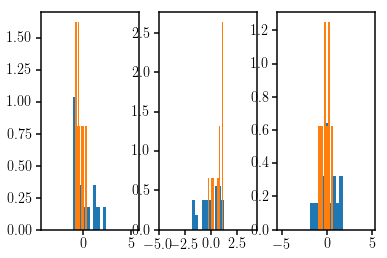

In [126]:
fig = plt.figure()
for i in range(np.min([3,n_comp])):
    sub = fig.add_subplot(1,3,i+1)
    _ = sub.hist(pc_lhd_white[:,i], normed=True) # LHD
    _ = sub.hist(pc_test_white[:,i], normed=True) # test

In [127]:
# train Gaussian processes on the LHD
gp_emu = trainGP_opt(theta_lhd[:,3:], pc_lhd_white)

In [128]:
# now evaluate at the test points
pc_test_pred_white, var_test_pred_white = emu(theta_test[:,3:], gp_emu, pc_lhd_white)

In [129]:
pc_test_pred = pc_test_pred_white * np.std(pc_lhd, axis=0) + np.mean(pc_lhd, axis=0)

In [130]:
for i in range(5): 
    print pc_test_pred_white[i,:4]
    print pc_test_white[i,:4]
    print (pc_test_pred_white[i,:4] - pc_test_white[i,:4])/pc_test_white[i,:4]

[-0.3699565   0.83674981 -0.16660352]
[-0.36727502  0.89632449  0.23058457]
[ 0.00730101 -0.06646553 -1.72252674]
[-0.52120894  0.74599238 -0.99972049]
[-0.51965573  0.77682997 -0.683738  ]
[ 0.00298894 -0.03969671  0.46213971]
[-0.44546279  0.82352625 -0.25606797]
[-0.44679787  0.84176293 -0.14547486]
[-0.0029881  -0.02166486  0.76022144]
[-0.0471253   1.1569477  -0.64775803]
[-0.0492976   1.2112558   0.60099253]
[-0.0440652  -0.0448362  -2.07781377]
[-0.16271986  1.17032995 -1.10783869]
[-0.16580247  1.19993018 -0.34728903]
[-0.01859211 -0.02466829  2.18996168]


In [131]:
print (pc_test_white[:5,:5] - pc_test_pred_white[:5,:5])/pc_test_white[:5,:5]

[[-0.00730101  0.06646553  1.72252674]
 [-0.00298894  0.03969671 -0.46213971]
 [ 0.0029881   0.02166486 -0.76022144]
 [ 0.0440652   0.0448362   2.07781377]
 [ 0.01859211  0.02466829 -2.18996168]]


(-2.0, 2.0)

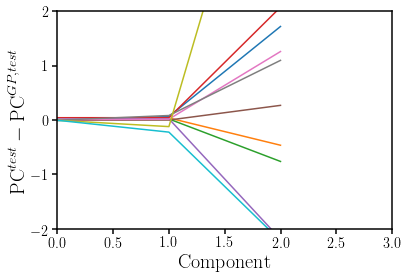

In [132]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pc_test_pred.shape[0]): 
    sub.plot(range(pc_test_pred.shape[1]), 1.- (pc_test_pred_white[i,:]/pc_test_white[i,:]))
sub.set_xlabel('Component', fontsize=20)
sub.set_xlim([0., pc_test_pred.shape[1]])
sub.set_ylabel('$\mathrm{PC}^{test} - \mathrm{PC}^{GP,test}$', fontsize=20)
sub.set_ylim([-2., 2.])

In [133]:
pk_test_pred = svd_lhd.inv_transform(pc_test_pred)

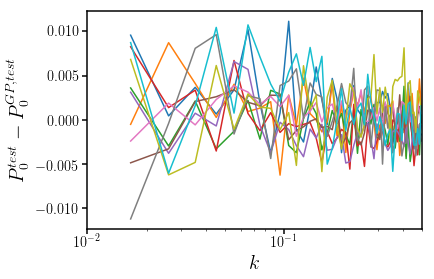

In [134]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pk_test_pred.shape[0]): 
    sub.plot(karr, 1. - pk_test_pred[i,:]/pk_test[i,:])
sub.set_xlabel('$k$', fontsize=20)
sub.set_xscale('log')
sub.set_xlim([0.01,0.5])
sub.set_ylabel('$P_0^{test} - P_0^{GP,test}$', fontsize=20)